In [26]:
import mujoco
import mujoco_viewer
import matplotlib.pyplot as plt
import numpy as np
import os
from lxml import etree
import mujoco.viewer
import time


In [27]:
xml = "xml.xml"
model = mujoco.MjModel.from_xml_path("xml.xml")
data = mujoco.MjData(model)


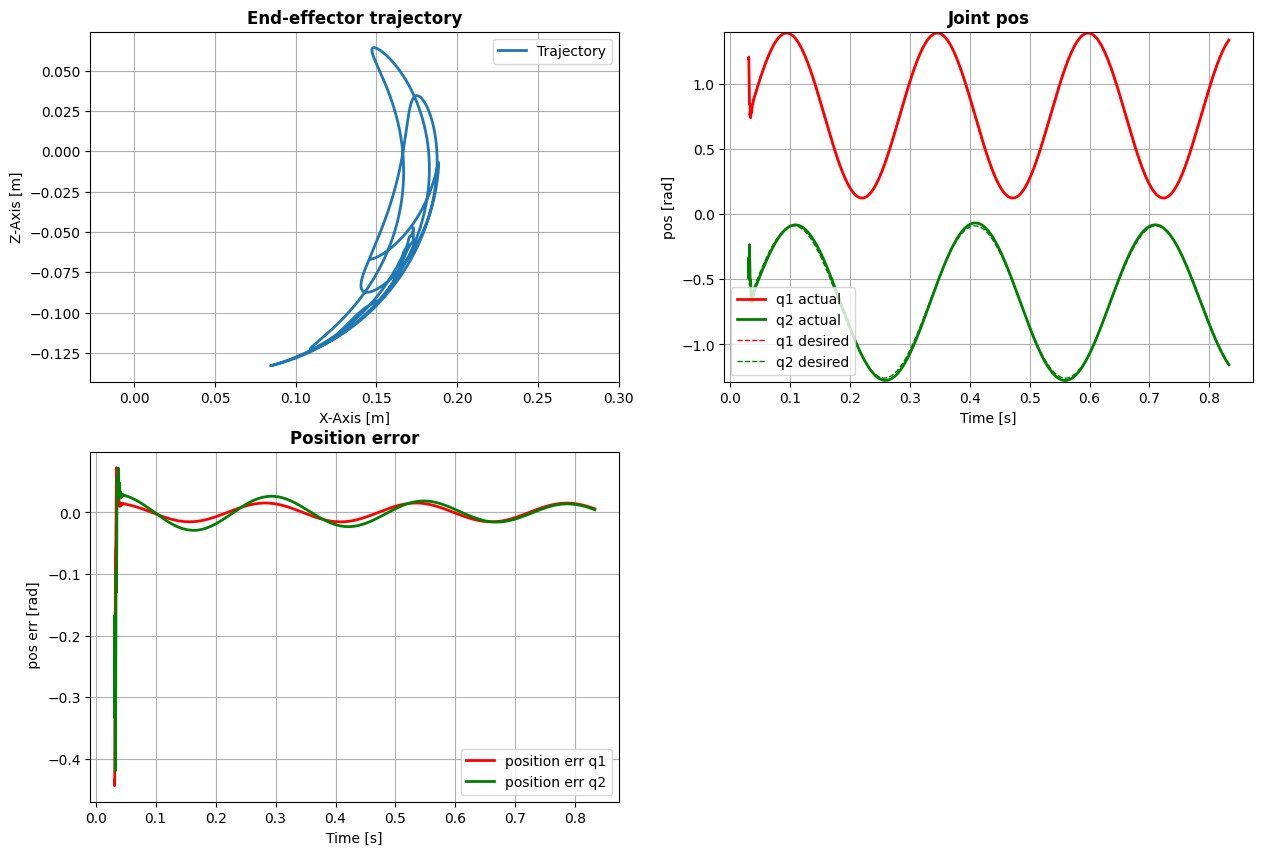

In [29]:
SIMEND = 20
TIMESTEP = 0.001
STEP_NUM = int(SIMEND / TIMESTEP)
timeseries = np.linspace(0, SIMEND, STEP_NUM)

A1 = np.deg2rad(36.33)
A2 = np.deg2rad(33.54)
F1 = 2.5
F2 = 2.08
B1 = np.deg2rad(43.5)
B2 = np.deg2rad(-38.6)
q_d1 = A1 * np.sin(F1 * timeseries) + B1
q_d2 = A2 * np.sin(F2 * timeseries) + B2
dq_d1 = A1 * F1 *np.cos(F1 * timeseries)
dq_d2 = A2 * F2 * np.cos(F2 * timeseries)


site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, "carriage")
q1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "q1")
q2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "q2")
q1_v_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "dq1")
q2_v_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "dq2")

KP = [150, 260]  
KV = [0.3, 0.4]
joint_A_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "A")
joint_B_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "B")

def set_torque(mj_data, KP, KV, q_desired,dq_des):
    tendon1_pos = mj_data.qpos[joint_A_id]
    tendon2_pos = mj_data.qpos[joint_B_id]
    tendon1_vel = mj_data.sensordata[q1_v_id]
    tendon2_vel = mj_data.sensordata[q2_v_id]
    data.ctrl[0] = KP[0] * (q_desired[0] - tendon1_pos) + KV[0] * (dq_des[0] - tendon1_vel)
    data.ctrl[1] = KP[1] * (q_desired[1] - tendon2_pos) + KV[1] * (dq_des[1] - tendon2_vel)

EE_position_x = []
EE_position_z = []
q1_pos = []
q2_pos = []
simulation_times = []
completed_steps = 0
EE_position_x = []
EE_position_z = []
site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, "carriage")
viewer = mujoco_viewer.MujocoViewer(model, 
                                    data,
                                    title="2R", 
                                    width=1920, 
                                    height=1080)


for i in range(STEP_NUM):
    if viewer.is_alive:

        set_torque(data, KP, KV, [q_d1[i], q_d2[i]],[dq_d1[i],dq_d1[i]])

        position_EE = data.site_xpos[site_id]
        EE_position_x.append(position_EE[0])
        EE_position_z.append(position_EE[2])
        # Сравним сенсоры и qpos
        current_q1 = data.qpos[joint_A_id]
        current_q2 = data.qpos[joint_B_id]

        q1_pos.append(current_q1)
        q2_pos.append(current_q2)

        simulation_times.append(data.time)
        mujoco.mj_step(model, data)
        viewer.render()
        completed_steps += 1
    else:
        break
viewer.close()

q_d1_completed = q_d1[:completed_steps]
q_d2_completed = q_d2[:completed_steps]
midlength = int(STEP_NUM/2)


plt.figure(figsize=(15, 10))

# График 1: Траектория конечного эффектора
plt.subplot(2, 2, 1)
plt.plot(EE_position_x, EE_position_z, '-', linewidth=2, label='Trajectory')
plt.title('End-effector trajectory', fontsize=12, fontweight='bold')
plt.xlabel('X-Axis [m]')
plt.ylabel('Z-Axis [m]')
plt.axis('equal')
plt.grid()
plt.legend()

# График 2: 
plt.subplot(2, 2, 2)
plt.plot(simulation_times, q1_pos, 'r-', linewidth=2, label='q1 actual')
plt.plot(simulation_times, q2_pos, 'g-', linewidth=2, label='q2 actual')
plt.plot(simulation_times, q_d1_completed, 'r--', linewidth=1, label='q1 desired')
plt.plot(simulation_times, q_d2_completed, 'g--', linewidth=1, label='q2 desired')
plt.title('Joint pos', fontsize=12, fontweight='bold')
plt.xlabel('Time [s]')
plt.ylabel('pos [rad]')
plt.grid()
plt.legend()
plt.ylim(min(min(q1_pos), min(q2_pos), min(q_d1_completed), min(q_d2_completed)) - 0.01,
         max(max(q1_pos), max(q2_pos), max(q_d1_completed), max(q_d2_completed)) + 0.01)
e1 = q_d1_completed-q1_pos
e2 = q_d2_completed-q2_pos

plt.subplot(2, 2, 3)
plt.plot(simulation_times, e1, 'r-', linewidth=2, label='position err q1')
plt.plot(simulation_times, e2, 'g-', linewidth=2, label='position err q2')
plt.title('Position error', fontsize=12, fontweight='bold')
plt.xlabel('Time [s]')
plt.ylabel(' pos err [rad]')
plt.grid()
plt.legend()

